# SMART GRID STABILITY PREDICTION PROJECT

In [115]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install seaborn
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams

import sklearn
from sklearn.model_selection import *
from sklearn.metrics import *
import sklearn.metrics as metrics
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


%matplotlib inline

rcParams['figure.figsize'] = 5, 4 
sns.set_style('whitegrid')


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## DATA INSPECTION

The local stability analysis of the 4-node star system (electricity producer is in the center) implementing Decentral Smart Grid Control concept. Attributes and goal fields: 
1. **tau[x]:** the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes)
2. **p[x]:** nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4)
3. **g[x]:**  price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma')
4. **stab:**  The maximal real part of the characteristic equation root (if positive - the system is linearly unstable)(real).
5. **stabf:** The stability label of the system (categorical: stable/unstable).

In [116]:
df = pd.read_csv('smart_grid_stability_augmented.csv')
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [23]:
df.isnull().sum() # No missing values across the columns

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

* **Since we want to predict whether the system is stable or not, we have to map 'stabf' column to binary values**

In [117]:
map1 = {'unstable': 0, 'stable': 1}
df['stabf'] = df['stabf'].replace(map1)
df.head()

C:\Users\akife\AppData\Local\Temp\ipykernel_23820\183478269.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['stabf'] = df['stabf'].replace(map1)


,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0


* **Using correlation matrix to see which variables are related**

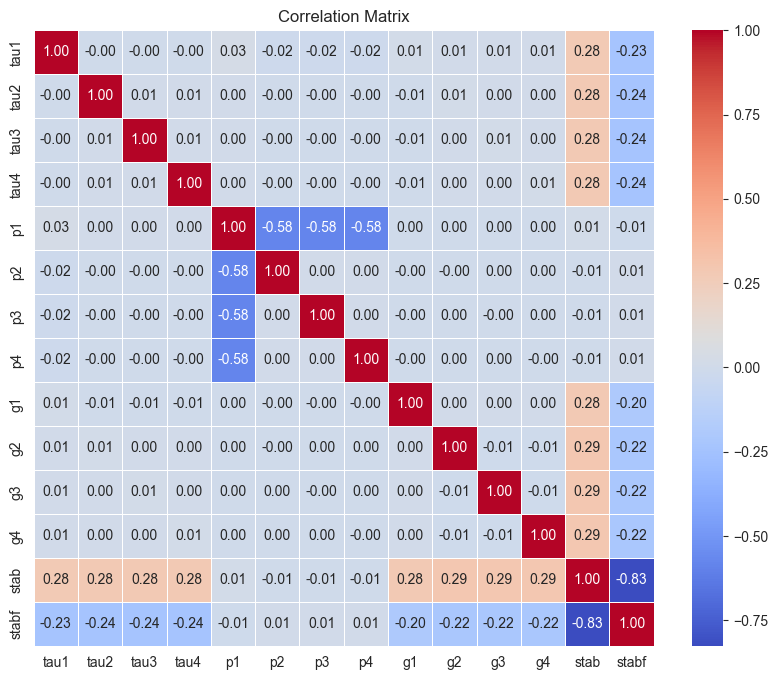

In [19]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

* **As there is a direct relationship between stab and stabf columns, we will drop stab column in order to prevent data leakage**

In [118]:
df= df.drop('stab', axis=1)
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0


## DATA SPLITTING

In [119]:
X = df.drop('stabf', axis=1)
y = df['stabf']

In [120]:
# Split the data into training set and test set (60% training, 20% validation, 20% test).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Fit the scaler to the training data and transform the training data.
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler.
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [121]:
#Check Percentage of Stable in Training, Validation and Test Set
print("Percentage of Stable grids in Training Set :", str(100*y_train.sum()/len(y_train))+'%')
print("Percentage of Stable grids in Validation Set :", str(100*y_val.sum()/len(y_val))+'%')
print("Percentage of Stable grids in Testing Set :",str(100*y_test.sum()/len(y_test))+'%')

Percentage of Stable grids in Training Set : 36.01111111111111%
Percentage of Stable grids in Validation Set : 36.43333333333333%
Percentage of Stable grids in Testing Set : 36.53333333333333%


## MODELING

### LOGISTIC REGRESSION

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]} # Regularization Parameter

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train) # fitting the estimator with best params
best_log_reg = grid_search.best_estimator_ # getting the best estimator
val_predictions = best_log_reg.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, val_predictions)

# Predictions on test set
test_predictions = best_log_reg.predict(X_test_scaled)

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, test_predictions)

print("Best parameters found:", grid_search.best_params_)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

Best parameters found: {'C': 0.001}
Validation Accuracy: 0.8139166666666666
Test Accuracy: 0.80925


In [25]:
# Accuracy
Accuracy0 = metrics.accuracy_score(y_test, test_predictions)

# Sensitivity (True Positive Rate o Recall)
Sensitivity0 = metrics.recall_score(y_test, test_predictions)

# Specificity (True Negative Rate)
Specificity0 = metrics.recall_score(y_test, test_predictions, pos_label=0)

# F1-score
F1_score0 = metrics.f1_score(y_test, test_predictions)
# F1-score = 2*(precision*recall)/(precision+recall)
# precision = True positives/True positives + False Positives
# recall = True positives/True positives + False Negatives
print({"Accuracy":Accuracy0,"Sensitivity":Sensitivity0,"Specificity":Specificity0,"F1_score":F1_score0})

{'Accuracy': 0.80925, 'Sensitivity': np.float64(0.6633211678832117), 'Specificity': np.float64(0.8932510504201681), 'F1_score': np.float64(0.7175817396668723)}


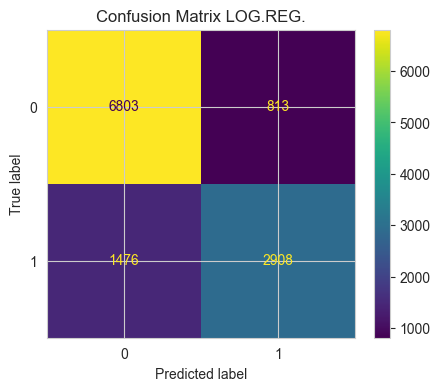

In [30]:
y_pred=best_log_reg.predict(X_test_scaled)
confusion_matrix0 = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix0)
cm_display.plot()
plt.title('Confusion Matrix LOG.REG.')
plt.show()

Roc AUC: 0.8882282497853157


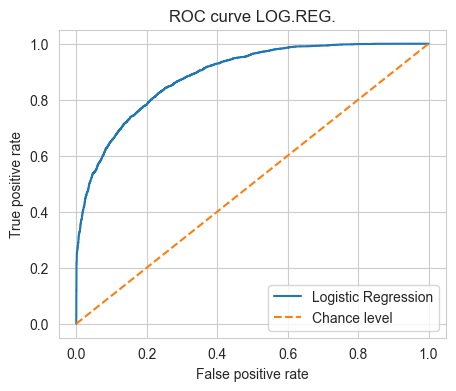

In [27]:
# I calculate the predicted probabilities from the model.
y_proba = best_log_reg.predict_proba(X_test_scaled)[:, 1]

# AUC-ROC
roc_auc0 = roc_auc_score(y_test, y_proba)
print("Roc AUC:", roc_auc0)

# I calculate the ROC curve using the predicted probabilities.
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# I plot the ROC curve.
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], ls="--", label='Chance level')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve LOG.REG.')
plt.legend(loc='best')
plt.show()

### KNN

In [35]:
param_grid = {'n_neighbors':[1,3,5,7,9,11]}

#Initialize the k-NN classifier
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')  # 5 katlı çapraz doğrulama

grid_search.fit(X_train_scaled, y_train)
best_k = grid_search.best_params_['n_neighbors']
best_knn = grid_search.best_estimator_
print('Best k value:', best_k)

# Predict on validation set
y_val_pred = best_knn.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Predict on test set
y_test_pred = best_knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Best k value: 11
Validation Accuracy: 0.8918333333333334
Test Accuracy: 0.8935


In [36]:
Accuracy7 = metrics.accuracy_score(y_test, y_test_pred)
Sensitivity7 = metrics.recall_score(y_test,y_test_pred)
Specificity7 = metrics.recall_score(y_test, y_test_pred,pos_label=0)
F1_score7 = metrics.f1_score(y_test, y_test_pred)
print({"Accuracy":Accuracy7,"Sensitivity":Sensitivity7,"Specificity":Specificity7,"F1_score":F1_score7})

{'Accuracy': 0.8935, 'Sensitivity': np.float64(0.7739507299270073), 'Specificity': np.float64(0.9623161764705882), 'F1_score': np.float64(0.8415178571428571)}


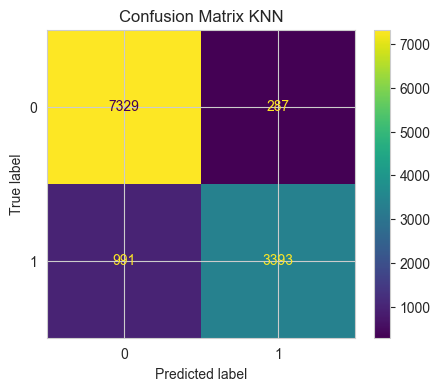

In [40]:
confusion_matrix = metrics.confusion_matrix(y_test, y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
cm_display.plot()
plt.title('Confusion Matrix KNN')
plt.show()

Roc AUC: 0.9665131549312242


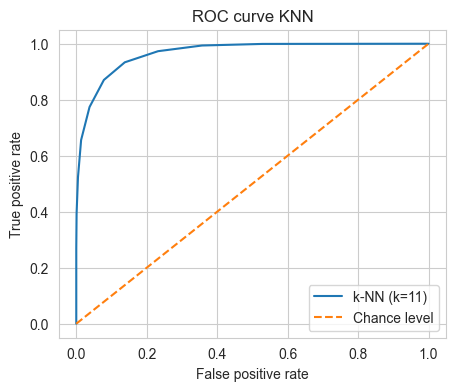

In [31]:
# Calculate the predicted probabilities from the model
y_proba = knn.predict_proba(X_test_scaled)[:, 1]

# Calculate the AUC-ROC using the predicted probabilities
roc_auc7 = roc_auc_score(y_test, y_proba)
print("Roc AUC:", roc_auc7)

# Calculate the ROC curve using the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='k-NN (k=11)')
plt.plot([0, 1], ls="--", label='Chance level')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve KNN')
plt.legend(loc='best')
plt.show()

### SVM

#### KERNEL LINEAR

In [22]:
# Define the parameters grid for grid search
param_grid = {
    'C': [0.1, 1]  # Regularization parameter
}

# Initialize SVM classifier with linear kernel
svm_classifier = SVC(kernel='linear')

# Perform grid search
grid_search = GridSearchCV(svm_classifier, param_grid, cv=3, scoring='accuracy')

X_train_for_param = X_train_scaled[:10000] # fitting 60000 rows(our full data) is not efficient to find parameters and fit the data to the SVM
y_train_for_param = y_train[:10000]
grid_search.fit(X_train_for_param, y_train_for_param)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

print("Best value of C:", best_params['C'])

# Train SVM classifier with the best parameters
best_svm_classifier = SVC(kernel='linear', **best_params)
best_svm_classifier.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred = best_svm_classifier.predict(X_val_scaled)

# Compute accuracy on validation set
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print accuracy on validation set
print("Validation Accuracy:", val_accuracy)

# Predict on test set
y_pred = best_svm_classifier.predict(X_test_scaled)

# Compute accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print accuracy on test set
print("Test Accuracy:", test_accuracy)

Best value of C: 0.1
Validation Accuracy: 0.8143333333333334
Test Accuracy: 0.80975


In [23]:
# metrics
Accuracy1 = metrics.accuracy_score(y_test, y_pred)
Sensitivity1 = metrics.recall_score(y_test,y_pred)
Specificity1 = metrics.recall_score(y_test, y_pred,pos_label=0)
F1_score1 = metrics.f1_score(y_test, y_pred)
print({"Accuracy":Accuracy1,"Sensitivity":Sensitivity1,"Specificity":Specificity1,"F1_score":F1_score1})

{'Accuracy': 0.80975, 'Sensitivity': np.float64(0.6911496350364964), 'Specificity': np.float64(0.8780199579831933), 'F1_score': np.float64(0.7263574253865516)}


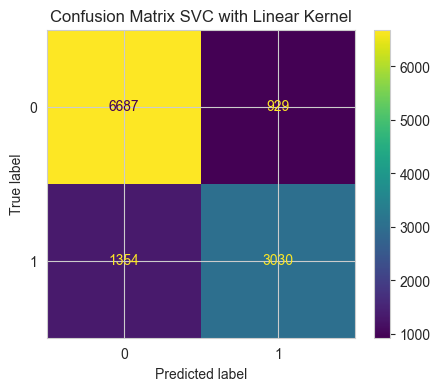

In [24]:
confusion_matrix1 = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix1)
cm_display.plot()
plt.title('Confusion Matrix SVC with Linear Kernel')
plt.show()

Roc AUC: 0.8881325882314604


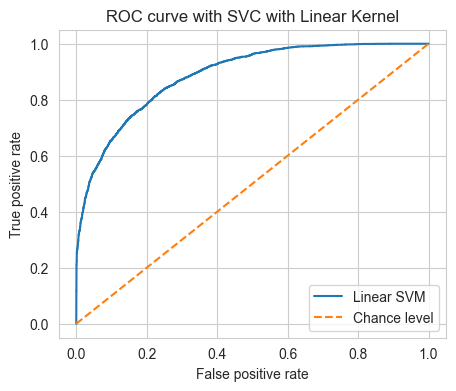

In [25]:
# calculate the predicted probabilities from the model.
y_proba = best_svm_classifier.decision_function(X_test_scaled)

# AUC-ROC
roc_auc1 = roc_auc_score(y_test, y_proba)
print("Roc AUC:", roc_auc1)

# calculate the ROC curve using the predicted probabilities.
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# plot the ROC curve.
plt.plot(fpr, tpr, label='Linear SVM')
plt.plot([0, 1], ls="--", label='Chance level')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve with SVC with Linear Kernel')
plt.legend(loc='best')
plt.show()

#### KERNEL POLYNOMIAL

In [26]:
# Define the parameters grid for grid search
param_grid = {
    'C': [0.1, 1],  # Regularization parameter
    'degree': [2, 3, 4],  # Degree of the polynomial kernel
}

# Initialize SVM classifier with polynomial kernel
svm_classifier = SVC(kernel='poly')

# Perform grid search
grid_search = GridSearchCV(svm_classifier, param_grid, cv=3, scoring='accuracy')

X_train_for_param = X_train_scaled[:10000] # fitting 60000 rows(our full data) is not efficient to find parameters and fit the data to the SVM
y_train_for_param = y_train[:10000]
grid_search.fit(X_train_for_param, y_train_for_param)

# Get the best parameters found by grid search
best_params = grid_search.best_params_
print("Best value of C:", best_params['C'])
print("Best value of degree:", best_params['degree'])

# Train SVM classifier with the best parameters
best_svm_classifier = SVC(kernel='poly', **best_params)
best_svm_classifier.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred = best_svm_classifier.predict(X_val_scaled)

# Compute accuracy on validation set
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print accuracy on validation set
print("Validation Accuracy:", val_accuracy)

# Predict on test set
y_pred = best_svm_classifier.predict(X_test_scaled)

# Compute accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)

# Print accuracy on test set
print("Test Accuracy:", test_accuracy)

Best value of C: 1
Best value of degree: 3
Validation Accuracy: 0.9043333333333333
Test Accuracy: 0.9014166666666666


In [27]:
Accuracy2 = metrics.accuracy_score(y_test, y_pred)
Sensitivity2 = metrics.recall_score(y_test,y_pred)
Specificity2 = metrics.recall_score(y_test, y_pred,pos_label=0)
F1_score2 = metrics.f1_score(y_test, y_pred)
print({"Accuracy":Accuracy2,"Sensitivity":Sensitivity2,"Specificity":Specificity2,"F1_score":F1_score2})

{'Accuracy': 0.9014166666666666, 'Sensitivity': np.float64(0.7618613138686131), 'Specificity': np.float64(0.9817489495798319), 'F1_score': np.float64(0.8495485183772097)}


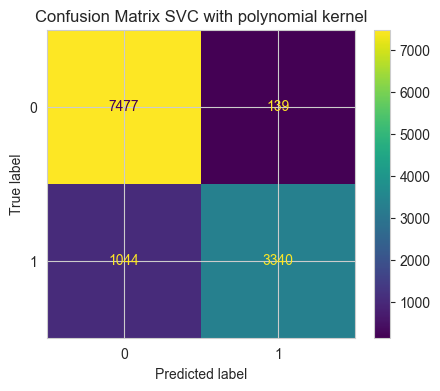

In [28]:
confusion_matrix2 = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix2)
cm_display.plot()
plt.title('Confusion Matrix SVC with polynomial kernel')
plt.show()

Roc AUC: 0.9213822561415077


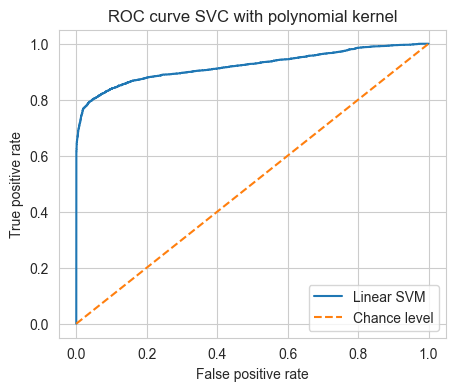

In [29]:
# Calculate the predicted probabilities from the model
y_proba = best_svm_classifier.decision_function(X_test_scaled)

# Calculate the AUC-ROC using the predicted probabilities
roc_auc2 = roc_auc_score(y_test, y_proba)
print("Roc AUC:", roc_auc2)

# Calculate the ROC curve using the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='Linear SVM')
plt.plot([0, 1], ls="--", label='Chance level')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve SVC with polynomial kernel')
plt.legend(loc='best')
plt.show()

#### KERNEL RBF

In [30]:
# Define the parameters grid for grid search
param_grid = {
    'C': [0.1, 1],  # Regularization parameter
    'gamma': [0.1, 1, 10]  # Kernel coefficient for 'rbf' kernel
}

svm_classifier = SVC(kernel='rbf')

grid_search = GridSearchCV(svm_classifier, param_grid, cv=3, scoring='accuracy')

X_train_for_param = X_train_scaled[:10000] # fitting 60000 rows(our full data) is not efficient to find parameters and fit the data to the SVM
y_train_for_param = y_train[:10000]
grid_search.fit(X_train_for_param, y_train_for_param)

# Get the best parameters found by grid search
best_params = grid_search.best_params_

# Train SVM classifier with the best parameters
best_svm_classifier = SVC(kernel='rbf', **best_params)
best_svm_classifier.fit(X_train_scaled, y_train)

print("Best value of C:", best_params['C'])
print("Best value of gamma:", best_params['gamma'])

# Predict on validation set
y_val_pred = best_svm_classifier.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Predict on test set
y_pred = best_svm_classifier.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

Best value of C: 1
Best value of gamma: 0.1
Validation Accuracy: 0.97625
Test Accuracy: 0.9771666666666666


In [31]:
Accuracy3 = metrics.accuracy_score(y_test, y_pred)
Sensitivity3 = metrics.recall_score(y_test,y_pred)
Specificity3 = metrics.recall_score(y_test, y_pred,pos_label=0)
F1_score3 = metrics.f1_score(y_test, y_pred)
print({"Accuracy":Accuracy3,"Sensitivity":Sensitivity3,"Specificity":Specificity3,"F1_score":F1_score3})

{'Accuracy': 0.9771666666666666, 'Sensitivity': np.float64(0.9641879562043796), 'Specificity': np.float64(0.9846376050420168), 'F1_score': np.float64(0.9686067827681026)}


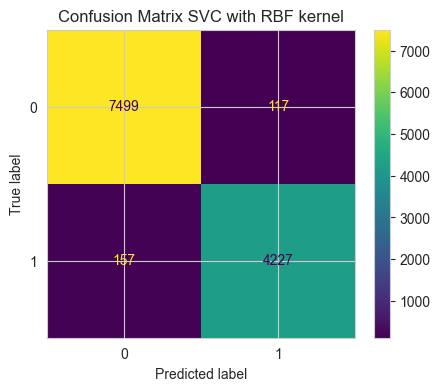

In [32]:
confusion_matrix3 = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix3)
cm_display.plot()
plt.title('Confusion Matrix SVC with RBF kernel')
plt.show()

Roc AUC: 0.9978100871963749


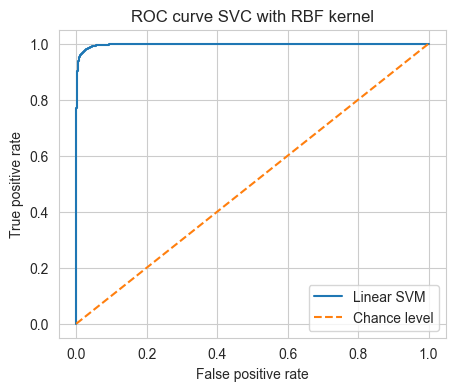

In [33]:
# Calculate the predicted probabilities from the model
y_proba = best_svm_classifier.decision_function(X_test_scaled)

# Calculate the AUC-ROC using the predicted probabilities
roc_auc3 = roc_auc_score(y_test, y_proba)
print("Roc AUC:", roc_auc3)

# Calculate the ROC curve using the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='Linear SVM')
plt.plot([0, 1], ls="--", label='Chance level')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve SVC with RBF kernel')
plt.legend(loc='best')
plt.show()

### KERNEL COMPARISON

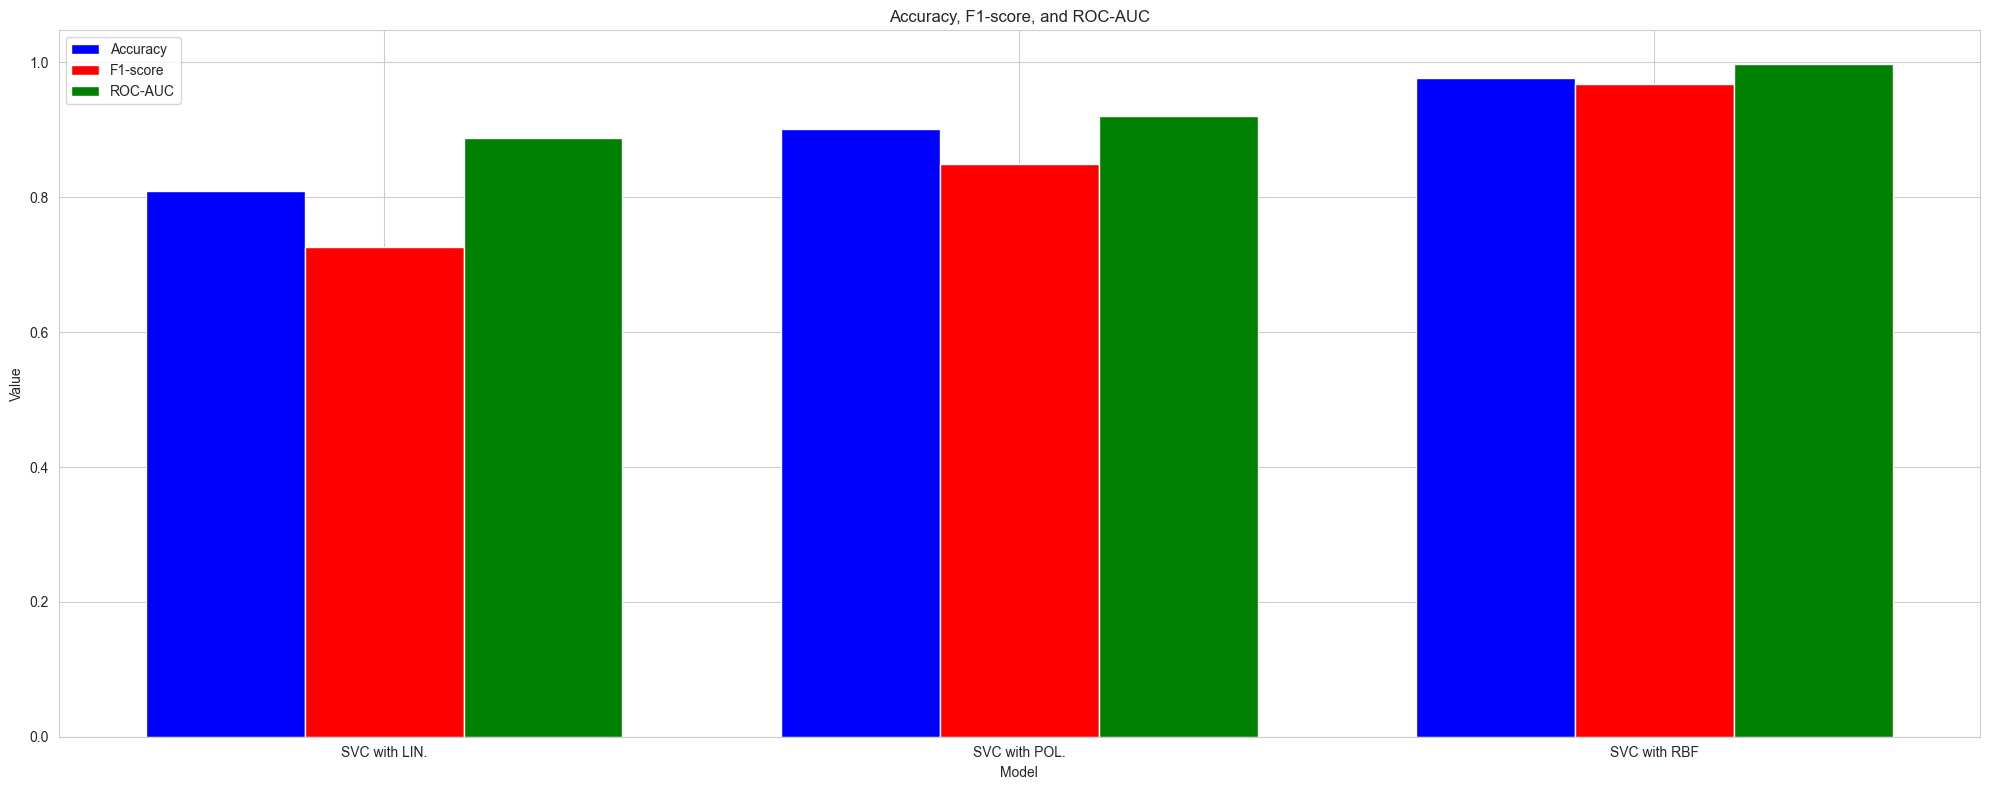

In [34]:
# Comparison
models = ['SVC with LIN.','SVC with POL.', 'SVC with RBF']
accuracyTOT = [Accuracy1, Accuracy2, Accuracy3]
f1_scoreTOT = [F1_score1, F1_score2, F1_score3]
roc_aucTOT = [roc_auc1, roc_auc2, roc_auc3]

bar_width = 0.25

index = np.arange(len(models))

plt.figure(figsize=(20, 8))

plt.bar(index, accuracyTOT, bar_width, color='b', label='Accuracy')
plt.bar(index + bar_width, f1_scoreTOT, bar_width, color='r', label='F1-score')
plt.bar(index + 2*bar_width, roc_aucTOT, bar_width, color='g', label='ROC-AUC')

plt.xlabel('Model')
plt.ylabel('Value')
plt.title('Accuracy, F1-score, and ROC-AUC')
plt.xticks(index + bar_width, models)
plt.legend()

plt.tight_layout()
plt.show()

# **-----------------------------------------------------------------------------------------**

## **NEURAL NETWORK IMPLEMENTATION(MLP) FOR SMART GRID STABILITY PREDICTION**

In [122]:
!pip install torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


* **Converting data to tensors**

In [241]:
# getting number of features
n_samples, n_features = X.shape

# converting to torch tensors because pytorch models and operations work with tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.to_numpy(), dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)

# pairing input and output data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# using DataLoader to handle batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


* **Implementing the model**

In [242]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.relu = nn.ReLU() # for non-linearity
        self.sigmoid = nn.Sigmoid()

    def forward(self, data):
        out = self.relu(self.fc1(data))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        out = self.sigmoid(out)
        
        return out

* **Model initialization, loss function and optimizer, learning rate scheduler**

In [243]:
# Model initialization
input_dim = X_train.shape[1]
model = MLP(input_dim=input_dim)

# Choosing loss function
criterion = nn.BCELoss() # takes probabilities as input from output layer(sigmoid)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

C:\Users\akife\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


* **Training loop and model evaluation**

In [244]:
# early stop and epoch
epochs = 100
early_stop_patience = 6
patience_counter = 0
min_val_loss = float('inf')

# to plot train and validation loss together to identify overfitting problem
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_train_batch, y_train_batch in train_loader:
        optimizer.zero_grad() # Resetting last step's gradients

        # forward pass
        y_train_pred = model(X_train_batch)
        loss = criterion(y_train_pred, y_train_batch)
        train_loss += loss.item()

        # backward pass
        loss.backward() # calculationg gradients
        optimizer.step() # updating model parameters
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        '''
        Since we do not update model parameters in evaluation, disable gradient computation for evaluation
        It improves memory and computational efficiency by avoiding unnecessary gradient calculations
        '''
        for X_val_batch, y_val_batch in val_loader:
            y_val_pred = model(X_val_batch)
            loss = criterion(y_val_pred, y_val_batch)

            val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch {epoch}, Train loss: {avg_train_loss: .2f}, Val loss: {avg_val_loss:.2f}')
    val_losses.append(avg_val_loss)
    
    # early stopping check
    if val_loss < min_val_loss:
        patience_counter = 0
        min_val_loss = val_loss
    else:
        patience_counter += 1

    if patience_counter > early_stop_patience:
        print('Early Stopping!!!')
        break  
        
    # Learning rate scheduler step
    scheduler.step(avg_val_loss)


Epoch 0, Train loss:  0.28, Val loss: 0.17
Epoch 1, Train loss:  0.15, Val loss: 0.13
Epoch 2, Train loss:  0.12, Val loss: 0.11
Epoch 3, Train loss:  0.10, Val loss: 0.09
Epoch 4, Train loss:  0.08, Val loss: 0.09
Epoch 5, Train loss:  0.08, Val loss: 0.08
Epoch 6, Train loss:  0.07, Val loss: 0.07
Epoch 7, Train loss:  0.06, Val loss: 0.07
Epoch 8, Train loss:  0.06, Val loss: 0.07
Epoch 9, Train loss:  0.06, Val loss: 0.07
Epoch 10, Train loss:  0.05, Val loss: 0.07
Epoch 11, Train loss:  0.05, Val loss: 0.06
Epoch 12, Train loss:  0.05, Val loss: 0.06
Epoch 13, Train loss:  0.05, Val loss: 0.06
Epoch 14, Train loss:  0.05, Val loss: 0.07
Epoch 15, Train loss:  0.05, Val loss: 0.07
Epoch 16, Train loss:  0.04, Val loss: 0.05
Epoch 17, Train loss:  0.04, Val loss: 0.06
Epoch 18, Train loss:  0.04, Val loss: 0.06
Epoch 19, Train loss:  0.04, Val loss: 0.06
Epoch 20, Train loss:  0.03, Val loss: 0.05
Epoch 21, Train loss:  0.03, Val loss: 0.05
Epoch 22, Train loss:  0.03, Val loss: 0.0

* **Train/Validation loss plot**

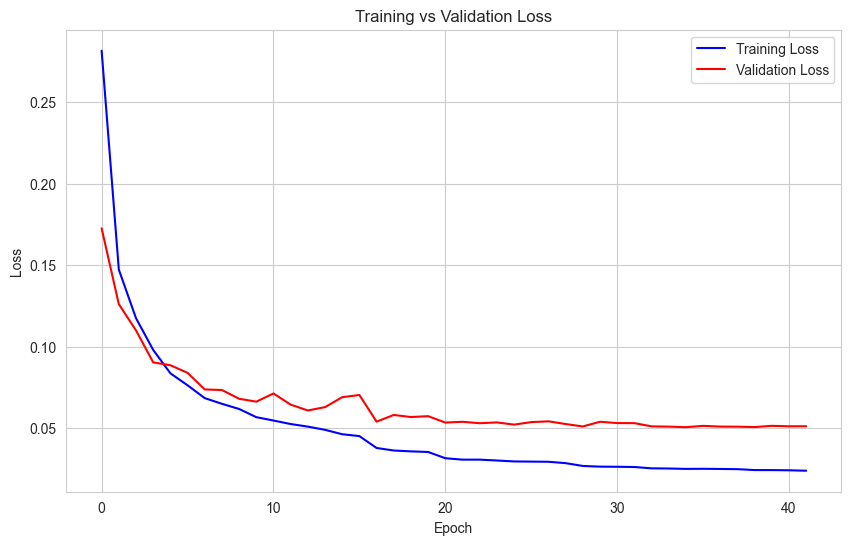

In [245]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

* **Testing the model**

In [246]:
all_preds = []
all_labels = []
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        y_test_pred = model(X_test_batch)
        loss = criterion(y_test_pred, y_test_batch)

        # since sigmoid returns probability value for every instance
        # we convert every value to binary using 0.5 as threshold value
        y_test_pred_binary = (y_test_pred > 0.5).float()

        all_preds.append(y_test_pred_binary)
        all_labels.append(y_test_batch)

        test_loss += loss.item()

# all_preds and all_labels are multi-dimensional because we append every batch output(which is a list) into these
# first we concat to get 1D array, we move the tensor to the CPU because numpy cannot handle GPU tensors
# finally we convert the tensor into numpy array
all_preds = torch.cat(all_preds).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.2f}')

Test Loss: 0.05


* **Confusion Matrix**

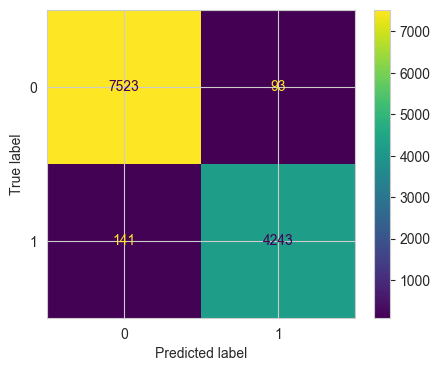

In [247]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

* **F1-score, precision and recall**

In [248]:
Accuracy = metrics.accuracy_score(all_labels, all_preds)
Sensitivity = metrics.recall_score(all_labels,all_preds)
Specificity = metrics.recall_score(all_labels, all_preds,pos_label=0)
F1_score = metrics.f1_score(all_labels, all_preds)
print({"Accuracy":Accuracy,"Sensitivity":Sensitivity,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.9805, 'Sensitivity': np.float64(0.9678375912408759), 'Specificity': np.float64(0.9877888655462185), 'F1_score': np.float64(0.9731651376146789)}
